# Project Part 1

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/sgeinitz/cs39aa_project/blob/main/project_part1.ipynb)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgeinitz/cs39aa_project/blob/main/project_part1.ipynb)

## Introduction/Background

The dataset that I am using is the Coronavirus tweets NLP - Text Classification from kaggle. The data is from twitter and it is manually tagged with the tweet informations such as @ handles, date, tweet content and with name and @ handles replaced with code to avoid any privacy concerns. This is a text classification problem since
This is a __text classification__ problem since we are categorizing Sentiment random tweets into predetermined categories of sentiments such as negative, positive and others. By definition, we are automatically analyzing and categorizing text into a number of predetermined categories.


## Exploratory Data Analysis

_You will now load the dataset and carry out some exploratory data analysis steps to better understand what text data looks like. See the examples from class on 10/. The following links provide some good resources of exploratory analyses of text data with Python._


* https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
* https://regenerativetoday.com/exploratory-data-analysis-of-text-data-including-visualization-and-sentiment-analysis/
* https://medium.com/swlh/text-summarization-guide-exploratory-data-analysis-on-text-data-4e22ce2dd6ad  
* https://www.kdnuggets.com/2019/05/complete-exploratory-data-analysis-visualization-text-data.html  


In [18]:
# import all of the python modules/packages you'll need here
import transformers
from torch.utils import data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

import datasets
from datasets import Dataset , Sequence , Value , Features , ClassLabel , DatasetDict

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import word_tokenize

import re, string

from tqdm import tqdm
from collections import defaultdict

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [19]:
df_train = pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_train.csv",encoding='latin')
df_test = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_test.csv',encoding='latin')

In [20]:
print(df_train.shape)
print(df_train.columns)
df_train.head()

(41157, 6)
Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


Drop unnessessary collumns and duplicates

In [21]:
df_train.drop(columns = ['UserName','ScreenName','Location','TweetAt'], inplace=True)
df_train.drop_duplicates(subset='OriginalTweet', inplace=True)
df_train = df_train.reset_index(drop=True)
df_train.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


Total sentiments and word per tweet satistics

In [22]:
df_train["Sentiment"].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

1 64


<AxesSubplot:xlabel='Word lengths', ylabel='Count'>

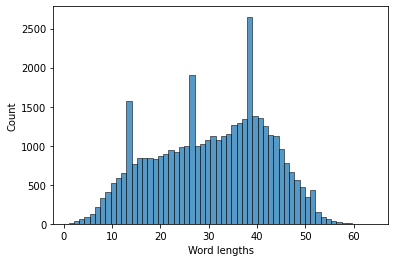

In [23]:
df_train['Word lengths'] = df_train['OriginalTweet'].apply(lambda t: len(t.split()))
min_len_word, max_len_word = df_train['Word lengths'].min(), df_train['Word lengths'].max()
print(min_len_word, max_len_word)
sns.histplot(df_train['Word lengths'])

In [24]:
df_train.describe()

,Word lengths
count,41157.000000
mean,30.500304
std,11.591172
min,1.000000
25%,21.000000
50%,32.000000
75%,40.000000
max,64.000000


Word Cloud

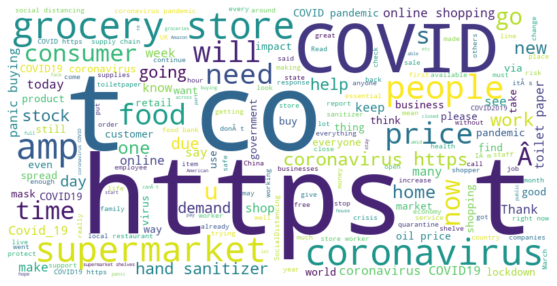

In [25]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(df_train.OriginalTweet))

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Cleanup the training dataset by removing whitespaces, numbers, unwanted errors

In [26]:
def createDataset(df, textCol, labelCol):
  dataset_dict = {
    'text' : df[textCol],
    'labels' : df[labelCol],
  }
  sent_tags = ClassLabel(num_classes=5 , names=['Extremely Negative', 'Negative','Neutral','Positive', 'Extremely Positive'])

  return Dataset.from_dict(
    mapping = dataset_dict,
    features = Features({'text' : Value(dtype='string') , 'labels' :sent_tags})
  )


In [27]:
dataset_train = createDataset(df_train,"OriginalTweet","Sentiment")
dataset_sentAnalysis = DatasetDict()
dataset_sentAnalysis["train"] = dataset_train
dataset_sentAnalysis

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 41157
    })
})

In [34]:
def convert_to_lower(text):
    return text.lower()

def remove_emojis(text):
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r"<.*?>","",text)

    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
    return wierd_pattern.sub(r'', text)

def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def preprocessText(text):
  return remove_extra_white_spaces(remove_stopwords(remove_punctuation(remove_numbers(remove_emojis(convert_to_lower(text))))))

def preprocessBatch(batch):
  new_list = []
  for i in batch["text"]:
    new_list.append(remove_extra_white_spaces(remove_stopwords(remove_punctuation(remove_numbers(remove_emojis(convert_to_lower(i)))))))
  batch["text"] = new_list
  return batch

In [35]:
dataset_sentAnalysis_preprocessed = dataset_sentAnalysis.map(preprocessBatch, batched=True, batch_size=32)

  0%|          | 0/1287 [00:00<?, ?ba/s]

In [36]:
dataset_sentAnalysis["train"][15]

{'text': 'Lines at the grocery store have been unpredictable, but is eating out a safe alternative? \r\r\n\r\r\nFind out more about whether you should be avoiding restaurants right now:  https://t.co/9idZSis5oQ\r\r\n\r\r\n#coronavirus #covid19 https://t.co/ZHbh898lf6',
 'labels': 3}

In [37]:
dataset_sentAnalysis_preprocessed["train"][15]

{'text': 'lines grocery store unpredictable eating safe alternative find whether avoiding restaurants right coronavirus covid',
 'labels': 3}